https://datawhalechina.github.io/llm-cookbook/#/C4/4.%20%E5%90%91%E9%87%8F%E6%95%B0%E6%8D%AE%E5%BA%93%E4%B8%8E%E8%AF%8D%E5%90%91%E9%87%8F%20Vectorstores%20and%20Embeddings

本章节需要安装第三方库pypdf、chromadb

检索增强生成（RAG）的整体工作流程：
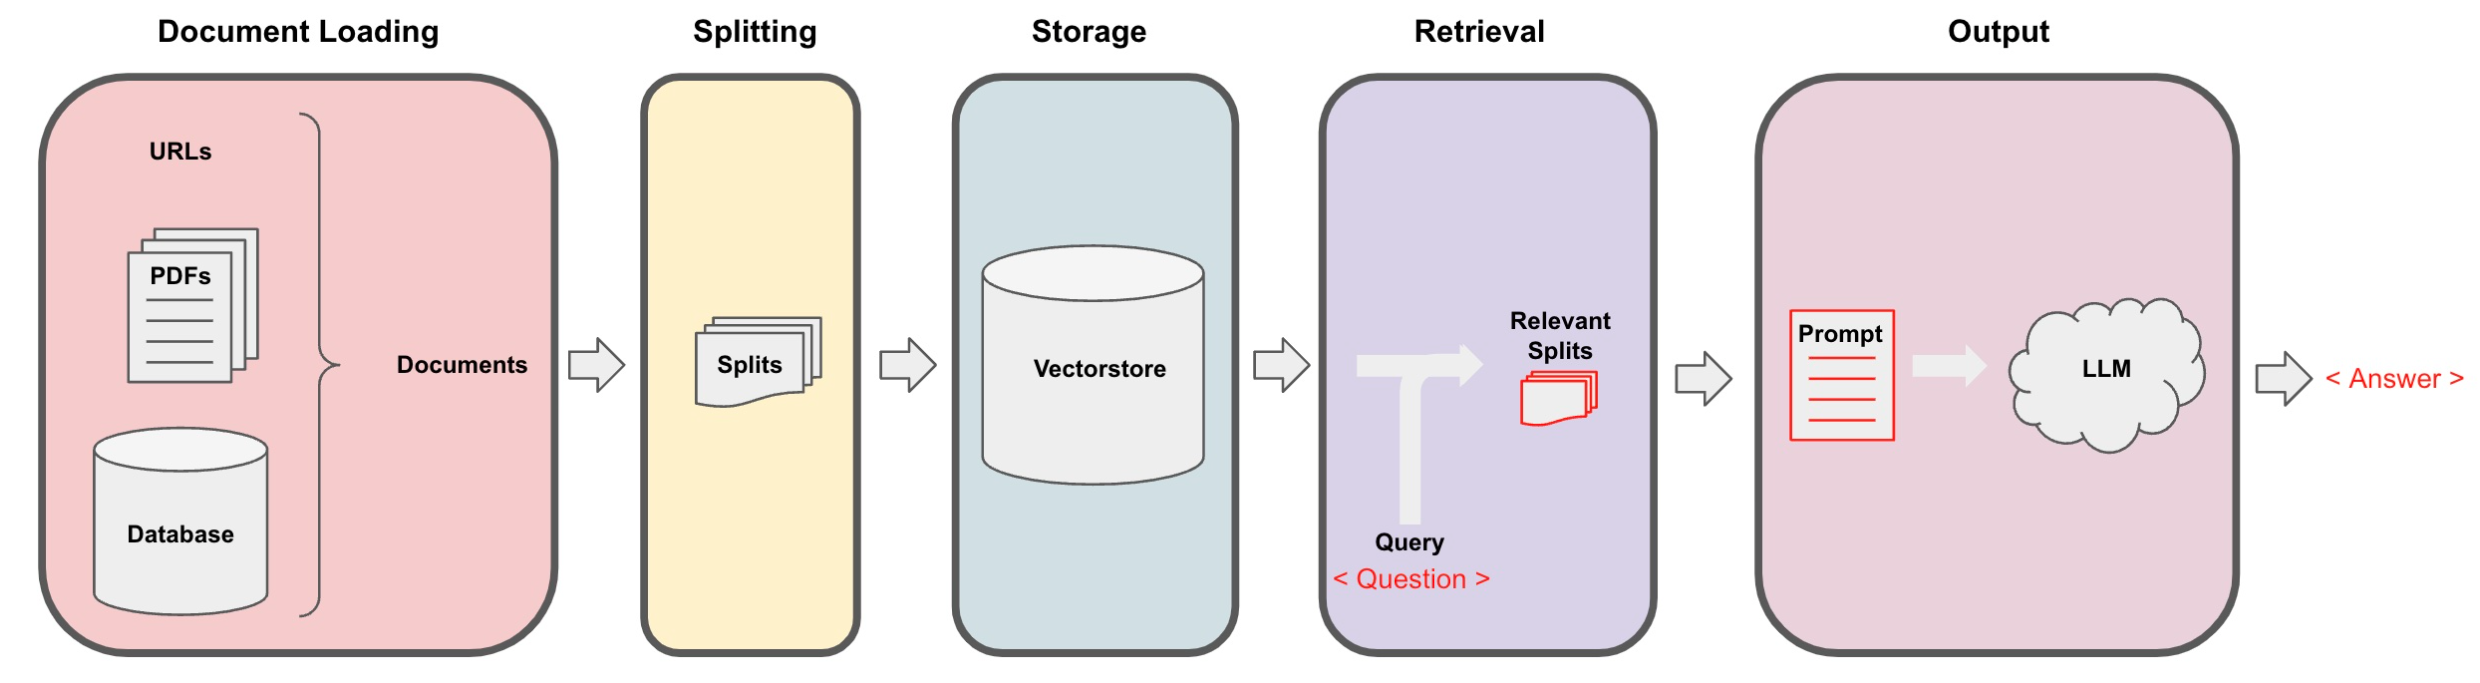

## 一、读取文档

In [24]:
from langchain.document_loaders import NotionDirectoryLoader

loader = NotionDirectoryLoader("./docs")
pages = loader.load()

使用 `RecursiveCharacterTextSplitter` 分割文本

In [25]:
# 分割文本
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,  # 每个文本块的大小。这意味着每次切分文本时，会尽量使每个块包含 1500 个字符。
    chunk_overlap = 150  # 每个文本块之间的重叠部分。
)

splits = text_splitter.split_documents(pages)

print(splits)
print(len(splits))


[Document(metadata={'source': 'docs\\Matplotlib初相识.md'}, page_content='---\njupytext:\n  text_representation:\n    format_name: myst\nkernelspec:\n  display_name: Python 3\n  name: python3\n---\n\n# 第一回：Matplotlib 初相识\n\n## 一、认识 matplotlib\n\nMatplotlib 是一个 Python 2D 绘图库，能够以多种硬拷贝格式和跨平台的交互式环境生成出版物质量的图形，用来绘制各种静态，动态，交互式的图表。\n\nMatplotlib 可用于 Python 脚本，Python 和 IPython Shell、Jupyter notebook，Web 应用程序服务器和各种图形用户界面工具包等。\n\nMatplotlib 是 Python 数据可视化库中的泰斗，它已经成为 python 中公认的数据可视化工具，我们所熟知的 pandas 和 seaborn 的绘图接口其实也是基于 matplotlib 所作的高级封装。\n\n为了对 matplotlib 有更好的理解，让我们从一些最基本的概念开始认识它，再逐渐过渡到一些高级技巧中。\n\n## 二、一个最简单的绘图例子\n\nMatplotlib 的图像是画在 figure（如 windows，jupyter 窗体）上的，每一个 figure 又包含了一个或多个 axes（一个可以指定坐标系的子区域）。最简单的创建 figure 以及 axes 的方式是通过`pyplot.subplots`命令，创建 axes 以后，可以使用`Axes.plot`绘制最简易的折线图。\n\n```{code-cell} ipython3\nimport matplotlib.pyplot as plt\nimport matplotlib as mpl\nimport numpy as np\n```\n\n```{code-cell} ipython3\nfig, ax = plt.subplots()  # 创建一个包含一个axes的figure\nax.plot([1, 2, 3, 4], [1,

## 二、Embeddings

### 什么是Embeddings？

在机器学习和自然语言处理（NLP）中，Embeddings（嵌入）是一种将类别数据，如单词、句子或者整个文档，转化为实数向量的技术。这些实数向量可以被计算机更好地理解和处理。嵌入背后的主要想法是，相似或相关的对象在嵌入空间中的距离应该很近。

举个例子，我们可以使用词嵌入（word embeddings）来表示文本数据。在词嵌入中，每个单词被转换为一个向量，这个向量捕获了这个单词的语义信息。例如，"king" 和 "queen" 这两个单词在嵌入空间中的位置将会非常接近，因为它们的含义相似。而 "apple" 和 "orange" 也会很接近，因为它们都是水果。而 "king" 和 "apple" 这两个单词在嵌入空间中的距离就会比较远，因为它们的含义不同。

让我们取出我们的切分部分并对它们进行Embedding处理。

In [26]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()


In [5]:
sentence1_chinese = "我喜欢狗"
sentence2_chinese = "我喜欢犬科动物"
sentence3_chinese = "外面的天气很糟糕"

embedding1_chinese = embedding.embed_query(sentence1_chinese)
embedding2_chinese = embedding.embed_query(sentence2_chinese)
embedding3_chinese = embedding.embed_query(sentence3_chinese)

## 嵌入，空间位置
print(embedding1_chinese)

[-0.015181282812305377, -0.008829797779264936, -0.018438121640474384, -0.025315113827737074, -0.048476302018489986, 0.006967819888671264, -0.01056850907126148, -0.005874637621584908, -0.008025319461982473, -0.018282417541672594, 0.006578555916376416, 0.018009933040462976, 0.0124694129865556, -0.0014986651058988601, -0.016673460907107664, 0.010808554675282545, 0.03604581645361872, 0.0024101909224301483, 0.018217539747295487, -0.00029255598735430574, -0.006607751016978372, 0.011859566189759264, 0.01881441135774544, -0.0367724417901777, -0.023758059801202866, 0.010380364212625953, 0.021357600035701856, -0.0014232453218612912, -0.014039443130758784, 0.001013707504484894, 0.046893295756617825, -0.004288388028787448, -0.031348702138678144, -0.006753724657342968, 0.009854858921048888, -0.0215392563698416, 0.007674981980049368, -0.003986708892637172, -0.006902942559955457, -0.020605024326450113, -0.011716836345981264, 0.019528061507958033, 0.0055113249533054205, 0.005508080691057528, 0.0024702

In [6]:
import numpy as np

# 坐标位置，1、2接近
np.dot(embedding1_chinese, embedding2_chinese)
np.dot(embedding2_chinese, embedding3_chinese)

0.7798953005415825

## Vectorstores
### 初始化Chroma
Langchain集成了超过30个不同的向量存储库。我们选择Chroma是因为它轻量级且数据存储在内存中，这使得它非常容易启动和开始使用。

创建向量数据库

In [27]:
from langchain.vectorstores import Chroma

persist_directory_chinese = 'docs/'

vectordb_chinese = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory_chinese  # 允许我们将persist_directory目录保存到磁盘上
)

print(vectordb_chinese._collection.count())

18


### 相似性搜索(Similarity Search)


In [40]:

question_chinese = "绘图的例子？" 

# 在向量数据库中检索答案
docs_chinese = vectordb_chinese.similarity_search(question_chinese,k=3)
print(docs_chinese[0].page_content)

```{code-cell} ipython3
# step1 准备数据
x = np.linspace(0, 2, 100)
y = x**2

# step2 设置绘图样式，这一模块的扩展参考第五章进一步学习，这一步不是必须的，样式也可以在绘制图像是进行设置
mpl.rc('lines', linewidth=4, linestyle='-.')

# step3 定义布局， 这一模块的扩展参考第三章进一步学习
fig, ax = plt.subplots()

# step4 绘制图像， 这一模块的扩展参考第二章进一步学习
ax.plot(x, y, label='linear')

# step5 添加标签，文字和图例，这一模块的扩展参考第四章进一步学习
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.set_title("Simple Plot")
ax.legend() ;
```

​

## 思考题

- 请思考两种绘图模式的优缺点和各自适合的使用场景
- 在第五节绘图模板中我们是以 OO 模式作为例子展示的，请思考并写一个 pyplot 绘图模式的简单模板
